In [1]:
import pandas as pd

# Load the data
data = pd.read_csv('yoochoose1.csv')
print(data.head())

# Check for missing values
print('Null values in data:')
print(data.isnull().sum())



   session_id       timestamp    item_id
0           5  7/4/2014 19:13  214530776
1           5  7/4/2014 19:20   21453077
2           5  7/4/2014 19:21  214530776
3          10   4/4/2014 9:44  214820942
4          10   4/4/2014 9:45  214826810
Null values in data:
session_id    0
timestamp     0
item_id       0
dtype: int64


In [2]:
print("\nDataset characteristics:")
print("Total number of interactions:", len(data))
print("Total number of sessions:", data['session_id'].nunique())
print("Total number of items:", data['item_id'].nunique())
print("Total number of users:", data['session_id'].nunique())

# Interactions per session
interactions_per_session = data.groupby('session_id').size()
print("\nInteractions per session:")
print(interactions_per_session.describe())



Dataset characteristics:
Total number of interactions: 1077
Total number of sessions: 294
Total number of items: 589
Total number of users: 294

Interactions per session:
count    294.000000
mean       3.663265
std        3.396275
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       41.000000
dtype: float64


In [3]:
# Average session length
average_session_length = interactions_per_session.mean()
print("\nAverage session length:", average_session_length)

# Sessions per item
sessions_per_item = data.groupby('item_id').size()
print("\nSessions per item:")
print(sessions_per_item.describe())




Average session length: 3.663265306122449

Sessions per item:
count    589.000000
mean       1.828523
std        1.770738
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       16.000000
dtype: float64


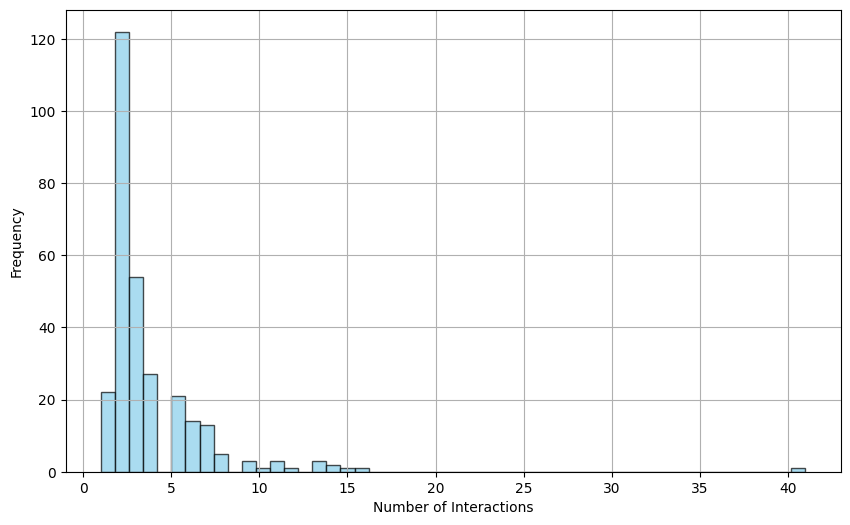

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(interactions_per_session, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Interactions')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Minimum session length: 1
Maximum session length: 41


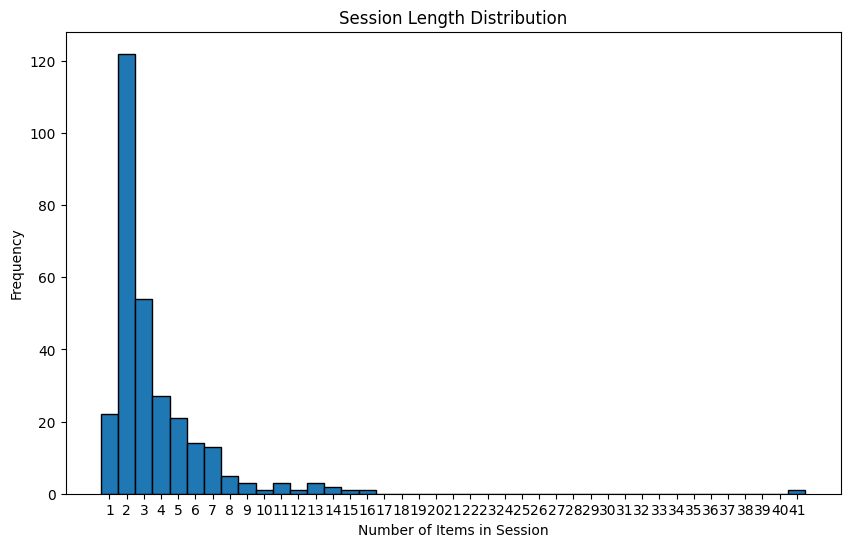

In [5]:

# Calculate session lengths
session_lengths = data.groupby('session_id').size()

# Print min and max session lengths
min_length = session_lengths.min()
max_length = session_lengths.max()
print(f"Minimum session length: {min_length}")
print(f"Maximum session length: {max_length}")

# Plot the session length distribution
plt.figure(figsize=(10, 6))
plt.hist(session_lengths, bins=range(min_length, max_length + 2), edgecolor='black', align='left')
plt.title('Session Length Distribution')
plt.xlabel('Number of Items in Session')
plt.ylabel('Frequency')
plt.xticks(range(min_length, max_length + 1))
plt.show()


Graph Structure:
Number of nodes: 462
Number of edges: 399


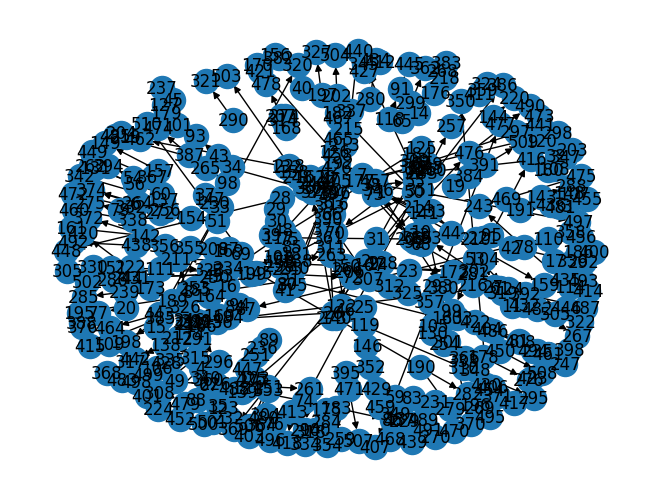

Params: {'hidden_feats': 32, 'out_feats': 64, 'learning_rate': 0.005, 'num_epochs': 20}, Average MRR: 0.9289
Params: {'hidden_feats': 128, 'out_feats': 64, 'learning_rate': 0.005, 'num_epochs': 10}, Average MRR: 0.9194
Params: {'hidden_feats': 64, 'out_feats': 64, 'learning_rate': 0.005, 'num_epochs': 30}, Average MRR: 0.9210
Params: {'hidden_feats': 128, 'out_feats': 32, 'learning_rate': 0.001, 'num_epochs': 30}, Average MRR: 0.9154
Params: {'hidden_feats': 128, 'out_feats': 16, 'learning_rate': 0.01, 'num_epochs': 30}, Average MRR: 0.9190
Params: {'hidden_feats': 32, 'out_feats': 64, 'learning_rate': 0.005, 'num_epochs': 20}, Average MRR: 0.9263
Params: {'hidden_feats': 128, 'out_feats': 32, 'learning_rate': 0.005, 'num_epochs': 10}, Average MRR: 0.9204
Params: {'hidden_feats': 32, 'out_feats': 64, 'learning_rate': 0.01, 'num_epochs': 30}, Average MRR: 0.9227
Params: {'hidden_feats': 128, 'out_feats': 64, 'learning_rate': 0.01, 'num_epochs': 30}, Average MRR: 0.9217
Params: {'hidden_

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, KFold
from numpy.random import default_rng
import numpy as np

def construct_graph(data):
    unique_items = data['item_id'].unique().tolist()
    item_to_node = {item: i for i, item in enumerate(unique_items)}

    g = nx.DiGraph()
    for _, session_group in data.groupby('session_id'):
        session_items = session_group['item_id'].unique()
        session_node_ids = [item_to_node[item_id] for item_id in session_items]
        for i in range(len(session_node_ids) - 1):
            src = session_node_ids[i]
            dst = session_node_ids[i + 1]
            time_diff = (session_group.iloc[i + 1]['timestamp'] - session_group.iloc[i]['timestamp']).total_seconds()
            g.add_edge(src, dst, time_diff=time_diff)

    return g, item_to_node

def print_graph_info(g):
    print("Graph Structure:")
    print("Number of nodes:", g.number_of_nodes())
    print("Number of edges:", g.number_of_edges())

    # Plot the graph
    nx.draw(g, with_labels=True)
    plt.show()

class TemporalGNNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_attention=True):
        super(TemporalGNNLayer, self).__init__()
        self.use_attention = use_attention
        self.fc = nn.Linear(in_feats, out_feats)
        if use_attention:
            self.attn_fc = nn.Linear(2 * out_feats, 1)

    def edge_attention(self, z_src, z_dst):
        z2 = torch.cat([z_src, z_dst], dim=1)
        a = self.attn_fc(z2)
        return F.leaky_relu(a)

    def forward(self, g, features):
        z = self.fc(features)
        new_features = torch.zeros_like(z)
        for node in g.nodes:
            neighbors = list(g.neighbors(node))
            if not neighbors:
                new_features[node] = z[node]
                continue
            neighbor_feats = z[neighbors]
            node_feat = z[node].unsqueeze(0).repeat(len(neighbors), 1)
            if self.use_attention:
                e = self.edge_attention(node_feat, neighbor_feats).squeeze()
                alpha = F.softmax(e, dim=0)
                if alpha.dim() == 1:
                    alpha = alpha.unsqueeze(1)
                new_features[node] = torch.sum(alpha * neighbor_feats, dim=0)
            else:
                new_features[node] = torch.mean(neighbor_feats, dim=0)
        return new_features

class TemporalGNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads=4):
        super(TemporalGNN, self).__init__()
        self.layer1 = TemporalGNNLayer(in_feats, hidden_feats, use_attention=True)
        self.layer2 = TemporalGNNLayer(hidden_feats, out_feats, use_attention=False)

    def forward(self, g, node_feats):
        h = self.layer1(g, node_feats)
        h = F.elu(h)
        h = self.layer2(g, h)
        return h

def train_model(model, optimizer, g, node_feats, session_data, item_to_node):
    model.train()
    optimizer.zero_grad()
    output = model(g, node_feats)
    loss = 0
    for _, session_group in session_data.groupby('session_id'):
        session_items = session_group['item_id'].unique()
        session_node_ids = [item_to_node[item_id] for item_id in session_items if item_id in item_to_node]
        session_node_feats = output[session_node_ids]
        pos_scores = torch.matmul(session_node_feats, session_node_feats.T).diagonal()
        neg_session_group = session_data[~session_data['session_id'].isin([session_group['session_id'].iloc[0]])]
        neg_session_items = neg_session_group['item_id'].unique()
        neg_session_node_ids = [item_to_node[item_id] for item_id in neg_session_items if item_id in item_to_node]
        neg_session_node_feats = output[neg_session_node_ids]
        neg_scores = torch.matmul(session_node_feats, neg_session_node_feats.T).diagonal()
        loss += F.relu(1 - (pos_scores - neg_scores)).mean()
    loss.backward()
    optimizer.step()
    return loss.item(), output

def recommend_items_for_session(session_id, session_data, top_n=5, output=None, item_to_node=None):
    session_items = session_data[session_data['session_id'] == session_id]['item_id'].unique()
    session_node_ids = [item_to_node[item_id] for item_id in session_items if item_id in item_to_node]
    session_node_feats = output[session_node_ids]
    similarity_scores = torch.matmul(session_node_feats, session_node_feats.T)
    similarity_scores = similarity_scores - torch.eye(similarity_scores.shape[0])
    top_indices = torch.topk(similarity_scores.mean(dim=0), min(top_n, similarity_scores.shape[0])).indices.tolist()
    recommended_items = [session_items[idx] for idx in top_indices]
    return recommended_items

def evaluate_performance(session_ids, true_items, session_data, k=5, output=None, item_to_node=None):
    mrr = 0
    recall = 0
    accuracy = 0
    precision = 0
    for session_id, true_item in zip(session_ids, true_items):
        recommended_items = recommend_items_for_session(session_id, session_data, top_n=k, output=output, item_to_node=item_to_node)
        if true_item in recommended_items:
            rank = recommended_items.index(true_item) + 1
            mrr += 1 / rank
            recall += 1
            accuracy += 1
            precision += 1 / len(recommended_items)
    mrr /= len(session_ids)
    recall /= len(session_ids)
    accuracy /= len(session_ids)
    precision /= len(session_ids)
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return mrr, recall, accuracy, precision, f1_score

def cross_validate(train_data, g, item_to_node, n_splits=5):
    param_distributions = {
        'hidden_feats': [32, 64, 128],
        'out_feats': [16, 32, 64],
        'learning_rate': [0.001, 0.005, 0.01],
        'num_epochs': [10, 20, 30]
    }

    best_score = 0
    best_params = None
    best_output = None

    n_samples = 10

    rng = default_rng()

    for _ in range(n_samples):
        params = {param: rng.choice(values) for param, values in param_distributions.items()}

        fold_scores = []

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        for train_index, val_index in kf.split(train_data):
            train_fold = train_data.iloc[train_index]
            val_fold = train_data.iloc[val_index]

            model = TemporalGNN(in_feats=len(item_to_node), hidden_feats=params['hidden_feats'], out_feats=params['out_feats'])
            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

            for epoch in range(params['num_epochs']):
                loss, output = train_model(model, optimizer, g, torch.eye(len(item_to_node)), train_fold, item_to_node)

            session_ids_val = val_fold['session_id'].unique()
            true_items_val = [val_fold[val_fold['session_id'] == session_id]['item_id'].iloc[-1] for session_id in session_ids_val]
            mrr, recall, accuracy, precision, f1_score = evaluate_performance(session_ids_val, true_items_val, val_fold, output=output, item_to_node=item_to_node)

            fold_scores.append(mrr)

        avg_mrr = np.mean(fold_scores)

        if avg_mrr > best_score:
            best_score = avg_mrr
            best_params = params
            best_output = output

        print(f"Params: {params}, Average MRR: {avg_mrr:.4f}")

    return best_params, best_score, best_output

data = pd.read_csv('yoochoose1.csv') #read data
data['timestamp'] = pd.to_datetime(data['timestamp'])

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

g, item_to_node = construct_graph(train_data)

print_graph_info(g)

best_params, best_score, best_output = cross_validate(train_data, g, item_to_node, n_splits=5)
print(f"Best Hyperparameters: {best_params}, Best Average MRR: {best_score:.4f}")

session_ids_test = test_data['session_id'].unique()
true_items_test = [test_data[test_data['session_id'] == session_id]['item_id'].iloc[-1] for session_id in session_ids_test]
mrr, recall, accuracy, precision, f1_score = evaluate_performance(session_ids_test, true_items_test, test_data, output=best_output, item_to_node=item_to_node)
print("Final Evaluation with Best Hyperparameters")
print("Mean Reciprocal Rank (MRR@5):", mrr)
print("Recall@5:", recall)
print("Precision@5:", precision)
print("F1-score@5:", f1_score)
print("Accuracy@5:", accuracy)
